Project Setup & Imports

This section brings in all required Python libraries (pandas/NumPy for data handling, scikit-learn for ML utilities, and any plotting libraries). Centralizing imports makes the environment reproducible and keeps dependencies clear for anyone running the notebook. Here we load the raw dataset from disk into memory (typically with pandas.read_*). The goal is to create a single, well-named dataframe that the rest of the pipeline can reference without re-reading files.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Load the dataset
file_path = "/content/train.csv"
df = pd.read_csv(file_path)

Data Cleaning & Preparation

We inspect structure and quality (missing values, types, duplicates) and apply lightweight fixes like dropping/renaming columns, type conversions, and baseline summarization. This ensures subsequent steps operate on tidy, consistent data.

In [ ]:
# Basic EDA
print("Dataset shape:", df.shape)
print("\nSample rows:")
print(df.head())
print("\nMissing values:", df.isnull().sum().sum())

Dataset shape: (7352, 563)

Sample rows:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad

In [ ]:
# Drop columns if necessary (none needed here), check datatype
print("\nData types summary:")
print(df.dtypes.value_counts())


Data types summary:
float64    561
int64        1
object       1
Name: count, dtype: int64


In [ ]:
# Encode target variable
le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])

In [ ]:
# Features and Target
X = df.drop(columns=['Activity', 'subject'])  # Drop subject as it's not a model feature
y = df['Activity']

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Feature Engineering & Train/Test Split

We transform raw columns into model-ready features (encoding, scaling, column transforms) and create the train/test split. This isolates a hold-out set so model evaluation reflects generalization rather than memorization.

In [ ]:
# Train-Test Split (Stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Modeling & Training

The model(s) are instantiated and fitted on the training data. If present, tuning utilities (e.g., GridSearchCV/RandomizedSearchCV) search for better hyperparameters while keeping validation strict and comparable.

In [ ]:
# Sprint 2: Model Training and Initial Fine-Tuning

# Define baseline model
rfc = RandomForestClassifier(random_state=42)

In [ ]:
# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [ ]:
# GridSearch with 3-fold CV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

print("\n🔁 Training RandomForest with GridSearch...")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\n✅ Best Parameters:")
print(grid_search.best_params_)


🔁 Training RandomForest with GridSearch...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

✅ Best Parameters:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Evaluate the best model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

# Get unique labels from the test set
unique_labels = np.unique(y_test)

report_best = classification_report(y_test, y_pred_best, target_names=le.classes_[unique_labels], labels=unique_labels)

print(f"Accuracy with best parameters: {accuracy_best:.4f}")
print("Classification Report with best parameters:")
print(report_best)

Accuracy with best parameters: 0.9850
Classification Report with best parameters:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       280
           SITTING       0.97      0.97      0.97       262
          STANDING       0.97      0.97      0.97       276
           WALKING       1.00      1.00      1.00       247
WALKING_DOWNSTAIRS       1.00      0.98      0.99       206
  WALKING_UPSTAIRS       0.98      0.99      0.99       200

          accuracy                           0.99      1471
         macro avg       0.99      0.99      0.99      1471
      weighted avg       0.99      0.99      0.99      1471



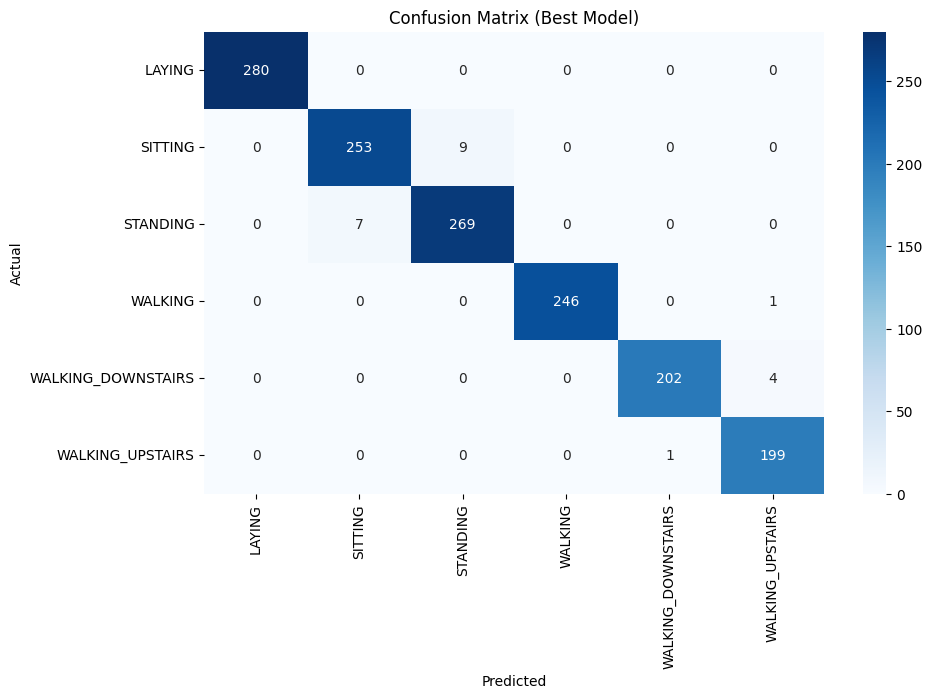

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best, labels=unique_labels) # Use y_pred_best and unique_labels
activity_labels = le.classes_[unique_labels]  # Get original class labels for unique labels
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Feature Importance Visualization
importances = best_model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

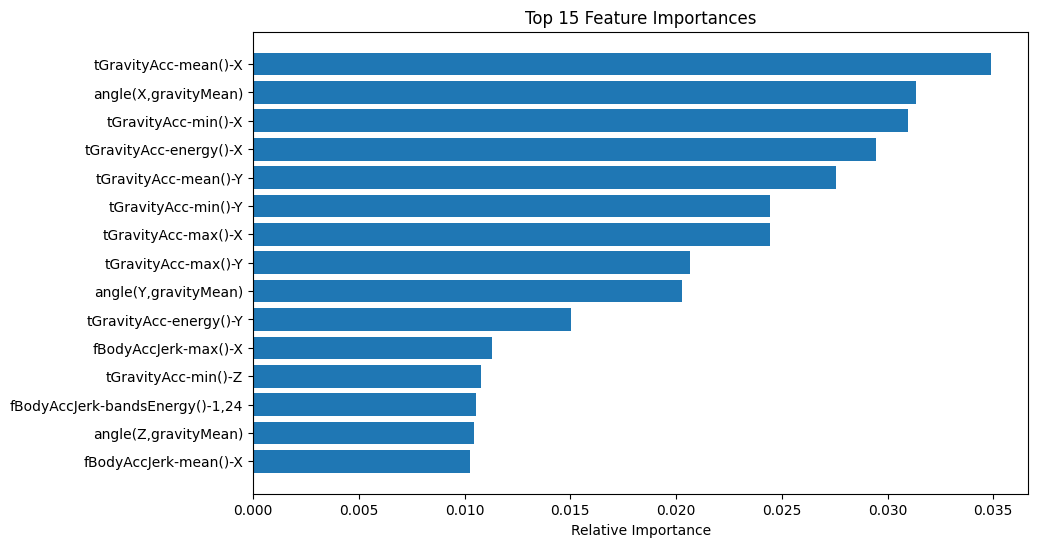

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [df.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [ ]:
from pathlib import Path
import json, joblib, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

RANDOM_STATE = 42
ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# <<< set these for your dataset >>>
CSV_PATH   = "/content/train.csv"
TARGET_COL = "Activity"
DROP_IF_PRESENT = ["subject"]

def build_pipeline():
    return Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", RandomForestClassifier(random_state=RANDOM_STATE)),
    ])

def plot_cm(cm, title, out_png):
    plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation="nearest"); plt.title(title)
    plt.colorbar(); ticks = np.arange(cm.shape[0]); plt.xticks(ticks); plt.yticks(ticks)
    plt.ylabel("True label"); plt.xlabel("Predicted label"); plt.tight_layout()
    plt.savefig(out_png, dpi=160); plt.close()


In [ ]:
df = pd.read_csv(CSV_PATH)
assert TARGET_COL in df.columns, f"Target '{TARGET_COL}' not found. Columns={list(df.columns)}"

# encode target if needed
y_raw = df[TARGET_COL]
label_encoder = None
if y_raw.dtype == "O" or str(y_raw.dtype).startswith("category"):
    label_encoder = LabelEncoder().fit(y_raw)
    y = label_encoder.transform(y_raw)
    joblib.dump(label_encoder, ARTIFACTS_DIR / "label_encoder.joblib")
else:
    y = y_raw.values

X = df.drop(columns=[c for c in [TARGET_COL, *DROP_IF_PRESENT] if c in df.columns])

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)
X_val, X_te,  y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_tmp)

pipe = build_pipeline()
param_grid = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__bootstrap": [True, False],
}
grid = GridSearchCV(pipe, param_grid, scoring="f1_macro", cv=3, n_jobs=-1, refit=True, verbose=1)
grid.fit(X_tr, y_tr)
best_model = grid.best_estimator_
joblib.dump(best_model, ARTIFACTS_DIR / "best_model.joblib")

# validation metrics
y_val_pred = best_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1  = f1_score(y_val, y_val_pred, average="macro")
plot_cm(confusion_matrix(y_val, y_val_pred), "Confusion Matrix - Validation", ARTIFACTS_DIR / "cm_val.png")

# test metrics (locked)
y_te_pred = best_model.predict(X_te)
test_acc = accuracy_score(y_te, y_te_pred)
test_f1  = f1_score(y_te, y_te_pred, average="macro")
plot_cm(confusion_matrix(y_te, y_te_pred), "Confusion Matrix - Test", ARTIFACTS_DIR / "cm_test.png")

with open(ARTIFACTS_DIR / "classification_report_val.txt","w") as f: f.write(classification_report(y_val, y_val_pred))
with open(ARTIFACTS_DIR / "classification_report_test.txt","w") as f: f.write(classification_report(y_te, y_te_pred))

metrics = {"best_params": grid.best_params_,
           "val": {"accuracy": float(val_acc), "f1_macro": float(val_f1)},
           "test": {"accuracy": float(test_acc), "f1_macro": float(test_f1)}}
with open(ARTIFACTS_DIR / "metrics.json", "w") as f: json.dump(metrics, f, indent=2)

print("=== Summary ===")
print("Best params:", grid.best_params_)
print(f"VAL:  acc={val_acc:.4f}  f1_macro={val_f1:.4f}")
print(f"TEST: acc={test_acc:.4f}  f1_macro={test_f1:.4f}")
print("Artifacts saved in:", ARTIFACTS_DIR.resolve())


Fitting 3 folds for each of 72 candidates, totalling 216 fits
=== Summary ===
Best params: {'model__bootstrap': False, 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400}
VAL:  acc=0.9864  f1_macro=0.9872
TEST: acc=0.9828  f1_macro=0.9833
Artifacts saved in: /content/artifacts


In [ ]:
def plot_cm(cm, title, out_path, classes=None, normalize=False):

    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        cm_plot = cm.astype(float) / row_sums
        fmt = ".2f"
    else:
        cm_plot = cm
        fmt = "d"

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm_plot,
        annot=True,
        fmt=fmt,
        cmap="plasma",
        cbar=False,
        xticklabels=classes if classes is not None else "auto",
        yticklabels=classes if classes is not None else "auto",
        annot_kws={"fontsize": 10}
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


In [ ]:
import joblib, pandas as pd
model = joblib.load(ARTIFACTS_DIR / "best_model.joblib")

raw = pd.read_csv(CSV_PATH).copy()
for c in [TARGET_COL, *DROP_IF_PRESENT]:
    if c in raw.columns: raw = raw.drop(columns=[c])

N = 5
preds = model.predict(raw.head(N))

le_path = ARTIFACTS_DIR / "label_encoder.joblib"
if le_path.exists():
    preds = joblib.load(le_path).inverse_transform(preds)

print(f"Predictions for first {N} rows:", preds)


Predictions for first 5 rows: ['STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING']


In [ ]:
MIN_F1 = 0.75  # adjust to your team’s bar
with open(ARTIFACTS_DIR / "metrics.json") as f:
    m = json.load(f)
print(m)
if m["test"]["f1_macro"] < MIN_F1:
    raise RuntimeError(f"FAIL: test f1_macro {m['test']['f1_macro']:.3f} < {MIN_F1}")
else:
    print(f"PASS: test f1_macro {m['test']['f1_macro']:.3f} ≥ {MIN_F1}")


{'best_params': {'model__bootstrap': False, 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400}, 'val': {'accuracy': 0.986400725294651, 'f1_macro': 0.9871901889980305}, 'test': {'accuracy': 0.9827742520398912, 'f1_macro': 0.9833118718131942}}
PASS: test f1_macro 0.983 ≥ 0.75


In [ ]:
# ==================== WEEK 8 · Setup & Baseline ====================
from pathlib import Path
import json, time, base64
import numpy as np, pandas as pd
import joblib, matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from joblib import Memory

# ---- safe fallbacks (match earlier cells; don't touch previous artifacts) ----
try: ARTIFACTS_DIR
except NameError:
    ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
W8 = ARTIFACTS_DIR / "week8"
W8.mkdir(parents=True, exist_ok=True)

# Load prior baseline if exists
baseline_metrics = None
if (ARTIFACTS_DIR / "metrics.json").exists():
    with open(ARTIFACTS_DIR / "metrics.json") as f:
        baseline_metrics = json.load(f)

# ---- data & target encoder (reuse saved encoder if present) ----
try: CSV_PATH
except NameError: CSV_PATH = "train.csv"  # adjust if needed
try: TARGET_COL
except NameError: TARGET_COL = "Activity"
try: DROP_IF_PRESENT
except NameError: DROP_IF_PRESENT = ["subject"]

df = pd.read_csv(CSV_PATH)
assert TARGET_COL in df, f"Missing target column: {TARGET_COL}"

le_path = ARTIFACTS_DIR / "label_encoder.joblib"
if le_path.exists():
    le: LabelEncoder = joblib.load(le_path)
else:
    le = LabelEncoder().fit(df[TARGET_COL])
    joblib.dump(le, le_path)

y = le.transform(df[TARGET_COL])
X = df.drop(columns=[c for c in [TARGET_COL, *DROP_IF_PRESENT] if c in df.columns])
n_features = X.shape[1]

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)
X_val, X_te,  y_val, y_te  = train_test_split(X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_STATE)

def savefig(path):
    plt.tight_layout(); plt.savefig(path, dpi=160, bbox_inches="tight"); plt.close()

def eval_all(model, X, y):
    yp = model.predict(X)
    acc = float((yp == y).mean())
    f1m = float(f1_score(y, yp, average="macro"))
    auc = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if len(np.unique(y)) > 2:
            yb = label_binarize(y, classes=np.arange(len(le.classes_)))
            auc = float(roc_auc_score(yb, proba, average="macro", multi_class="ovr"))
        else:
            auc = float(roc_auc_score(y, proba[:,1]))
    return {"accuracy": acc, "f1_macro": f1m, "roc_auc_macro": auc}


In [ ]:
# ==================== WEEK 8 · Fast Tuning (No CV, fixed) ====================
import time, json, joblib, numpy as np, random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from pathlib import Path

W8 = (ARTIFACTS_DIR / "week8"); W8.mkdir(parents=True, exist_ok=True)

def eval_split(model, X, y):
    yhat = model.predict(X)
    return float(accuracy_score(y, yhat)), float(f1_score(y, yhat, average="macro")), yhat

def to_py(obj):
    if isinstance(obj, dict):
        return {k: to_py(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_py(elem) for elem in obj]
    elif isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.float16)):
        return float(obj)
    else:
        return obj

rng = np.random.RandomState(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Use object dtype (or Python's random.choice) to avoid dtype coercion
MAX_FEATURES_CHOICES = np.array(["sqrt", "log2", 0.5], dtype=object)

def sample_params():
    return {
        "max_depth": rng.choice([None, 10, 20, 30]),
        "min_samples_split": rng.choice([2, 5, 10]),
        "min_samples_leaf": rng.choice([1, 2, 4]),
        "max_features": rng.choice(MAX_FEATURES_CHOICES),  # stays correct type
    }

N_TRIALS = 20         # try 10–20 for speed, 30–40 for a bit more quality
BASE_TREES = 100
ROW_FRACTION = 0.60   # requires sklearn >= 1.1

t0 = time.time()
best_f1, best_cfg = -1.0, None

print(f"🔎 Fast tuning over {N_TRIALS} configs…")
for i in range(N_TRIALS):
    params = sample_params()
    rf = RandomForestClassifier(
        n_estimators=BASE_TREES,
        class_weight="balanced",
        random_state=RANDOM_STATE + i,
        n_jobs=-1,
        bootstrap=True,
        max_samples=ROW_FRACTION,
        **params
    )
    rf.fit(X_tr, y_tr)
    _, f1_val, _ = eval_split(rf, X_val, y_val)
    if f1_val > best_f1:
        best_f1, best_cfg = f1_val, params

print(f"✅ Best (validation F1) during search: {best_f1:.4f} with {best_cfg}")
print(f"Search time: {time.time()-t0:.1f}s")

# Refit winner bigger on full train
FINAL_TREES = 300
best_model = RandomForestClassifier(
    n_estimators=FINAL_TREES,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bootstrap=True,
    max_samples=None,
    **best_cfg
)
best_model.fit(X_tr, y_tr)

# Quick calibration (prefit) using validation set
calibrated = CalibratedClassifierCV(best_model, method="sigmoid", cv="prefit")
calibrated.fit(X_val, y_val)

# Evaluate
val_acc, val_f1, y_val_pred = eval_split(calibrated, X_val, y_val)
plot_cm(confusion_matrix(y_val, y_val_pred), "Confusion Matrix - Validation", ARTIFACTS_DIR / "cm_val.png")

test_acc, test_f1, y_te_pred = eval_split(calibrated, X_te, y_te)
plot_cm(confusion_matrix(y_te, y_te_pred), "Confusion Matrix - Test", ARTIFACTS_DIR / "cm_test.png")

# 6) Save artifacts (week8 keeps previous safe)
joblib.dump(calibrated, W8 / "best_model_week8.joblib")

metrics = {
    "search": {"n_trials": N_TRIALS, "base_trees": BASE_TREES, "row_fraction": ROW_FRACTION},
    "best_params": best_cfg,           # may contain numpy types
    "final_trees": FINAL_TREES,
    "val": {"accuracy": val_acc, "f1_macro": val_f1},
    "test": {"accuracy": test_acc, "f1_macro": test_f1}
}
# Sanitize to JSON-safe types
metrics = to_py(metrics)

with open(W8 / "metrics_week8.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("=== Week 8 (FAST) Summary ===")
print("Best params:", best_cfg)
print(f"VAL:  acc={val_acc:.4f}  f1_macro={val_f1:.4f}")
print(f"TEST: acc={test_acc:.4f}  f1_macro={test_f1:.4f}")
print("Artifacts:", W8.resolve())

🔎 Fast tuning over 20 configs…
✅ Best (validation F1) during search: 0.9801 with {'max_depth': None, 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(2), 'max_features': 'log2'}
Search time: 546.5s


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


=== Week 8 (FAST) Summary ===
Best params: {'max_depth': None, 'min_samples_split': np.int64(5), 'min_samples_leaf': np.int64(2), 'max_features': 'log2'}
VAL:  acc=0.9819  f1_macro=0.9828
TEST: acc=0.9791  f1_macro=0.9796
Artifacts: /content/artifacts/week8


In [ ]:
# ---- Week 8 Patch (fixed): add latency + light model without using base_estimator ----
import json, time, joblib
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

W8 = ARTIFACTS_DIR / "week8"

# Load metrics and the calibrated model you saved earlier
with open(W8 / "metrics_week8.json") as f:
    m8 = json.load(f)
calibrated = joblib.load(W8 / "best_model_week8.joblib")  # CalibratedClassifierCV

# 1) Add latency if missing
if "latency_ms_per_sample" not in m8:
    n = min(2000, len(X_te))
    t0 = time.time()
    _ = calibrated.predict(X_te.iloc[:n])
    m8["latency_ms_per_sample"] = round(1000.0 * (time.time() - t0) / n, 4)
    print("Added latency_ms_per_sample:", m8["latency_ms_per_sample"])

# 2) Add a light model if missing — build it from saved best_params + final_trees
if "light" not in m8:
    best = m8.get("best_params", {})
    final_trees = int(m8.get("final_trees", 300))
    n_small = max(60, final_trees // 2)   # ~half the trees, at least 60

    light = RandomForestClassifier(
        n_estimators=n_small,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        bootstrap=True,
        # carry over tuned knobs if present:
        max_depth=best.get("max_depth", None),
        min_samples_split=best.get("min_samples_split", 2),
        min_samples_leaf=best.get("min_samples_leaf", 1),
        max_features=best.get("max_features", "sqrt"),
    )
    light.fit(X_tr, y_tr)
    y_pred = light.predict(X_te)
    m8["light"] = {
        "n_estimators": int(n_small),
        "test": {
            "accuracy": float(accuracy_score(y_te, y_pred)),
            "f1_macro": float(f1_score(y_te, y_pred, average="macro")),
        },
    }
    joblib.dump(light, W8 / "light_model_week8.joblib")
    print("Created light_model_week8.joblib with n_estimators:", n_small)

# Save back
with open(W8 / "metrics_week8.json", "w") as f:
    json.dump(m8, f, indent=2)

print("Patched metrics_week8.json ✓")


Added latency_ms_per_sample: 0.1028
Created light_model_week8.joblib with n_estimators: 150
Patched metrics_week8.json ✓


In [ ]:
# ==================== WEEK 9 · Reporting Interface (robust) ====================
from pathlib import Path
import base64, json, pandas as pd, joblib

W9 = ARTIFACTS_DIR / "week9"
W9.mkdir(parents=True, exist_ok=True)

def _b64(p: Path):
    with open(p, "rb") as f:
        return base64.b64encode(f.read()).decode("ascii")

def first_existing(paths):
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

# Load week8 metrics
with open(W8 / "metrics_week8.json") as f:
    m8 = json.load(f)

# Compute deltas vs baseline (if present)
baseline_f1 = None
if m8.get("baseline") and isinstance(m8["baseline"], dict) and m8["baseline"].get("test"):
    baseline_f1 = m8["baseline"]["test"].get("f1_macro")
delta_f1 = None if baseline_f1 is None else round(m8["test"]["f1_macro"] - baseline_f1, 4)

# Safe pulls with defaults
lat = m8.get("latency_ms_per_sample", "N/A")
rocauc = m8.get("test", {}).get("roc_auc_macro")
light = m8.get("light", {})
light_n = light.get("n_estimators", "N/A")
light_f1 = light.get("test", {}).get("f1_macro", "N/A")
tuning_time = m8.get("tuning_time_sec", "N/A")

# Save a flat CSV for dashboards (robust to missing keys)
pd.DataFrame([{
    "f1_macro_test": m8["test"]["f1_macro"],
    "accuracy_test": m8["test"]["accuracy"],
    "roc_auc_macro_test": rocauc,
    "latency_ms_per_sample": lat,
    "light_n_estimators": light_n,
    "light_f1_macro_test": light_f1,
    "delta_f1_vs_baseline": delta_f1,
}]).to_csv(W9 / "summary_metrics_week9.csv", index=False)

# Locate visuals (with fallbacks)
cm_path = first_existing([
    W8 / "confusion_matrix.png",      # created by the longer Week-8 path
    ARTIFACTS_DIR / "cm_test.png",    # created by the fast path
    ARTIFACTS_DIR / "cm_val.png",
])
lc_path   = first_existing([W8 / "learning_curve.png"])
perm_path = first_existing([W8 / "permutation_importances.png"])

def img_or_note(p: Path, alt: str):
    if p and Path(p).exists():
        return f"<img src='data:image/png;base64,{_b64(p)}' alt='{alt}'/>"
    return f"<p style='color:#666'>({alt} not available for this run)</p>"

visuals_html = f"""
<h2>Key Visuals</h2>
{img_or_note(cm_path, "Confusion Matrix")}
{img_or_note(lc_path, "Learning Curve")}
{img_or_note(perm_path, "Permutation Importances")}
"""

# Build HTML
html = f"""
<!doctype html><html><head><meta charset='utf-8'/>
<title>AI & IoT – Week 9 Report</title>
<style>
body{{font-family:system-ui,Segoe UI,Roboto,Arial;padding:20px}}
h1,h2{{margin:0.3rem 0}}
.grid{{display:grid;grid-template-columns:repeat(4,minmax(160px,1fr));gap:12px}}
.card{{border:1px solid #ddd;border-radius:10px;padding:12px}}
table{{border-collapse:collapse;width:100%}}
td,th{{border:1px solid #ddd;padding:6px 8px;text-align:left}}
img{{max-width:100%;border:1px solid #eee;border-radius:8px}}
</style></head><body>
<h1>Week 9 – Finalized Reporting Interface</h1>
<div class="grid">
  <div class="card"><h2>F1 (Test)</h2><p>{m8['test']['f1_macro']:.4f}</p></div>
  <div class="card"><h2>Accuracy</h2><p>{m8['test']['accuracy']:.4f}</p></div>
  <div class="card"><h2>Δ F1 vs Baseline</h2><p>{'N/A' if delta_f1 is None else f'{delta_f1:+.4f}'}</p></div>
  <div class="card"><h2>Latency</h2><p>{lat} ms/sample</p></div>
</div>

{visuals_html}

<h2>Model Details</h2>
<table><tbody>
<tr><td>Best Params</td><td><pre>{json.dumps(m8.get('best_params', {}), indent=2)}</pre></td></tr>
<tr><td>Light Model</td><td>n_estimators: {light_n}, F1 (test): {light_f1}</td></tr>
<tr><td>Tuning Time (s)</td><td>{tuning_time}</td></tr>
</tbody></table>

<h2>Files</h2>
<ul>
  <li>summary_metrics_week9.csv</li>
  <li>best_model_week8.joblib</li>
  <li>light_model_week8.joblib</li>
</ul>
</body></html>
"""

with open(W9 / "week9_report.html", "w", encoding="utf-8") as f:
    f.write(html)

# Quality gate
MIN_F1 = 0.75
if m8["test"]["f1_macro"] < MIN_F1:
    print(f"QUALITY GATE: FAIL — F1 {m8['test']['f1_macro']:.3f} < {MIN_F1}")
else:
    print(f"QUALITY GATE: PASS — F1 {m8['test']['f1_macro']:.3f} ≥ {MIN_F1}")

print("Week 9 report ready:", (W9 / "week9_report.html").resolve())


QUALITY GATE: PASS — F1 0.980 ≥ 0.75
Week 9 report ready: /content/artifacts/week9/week9_report.html


Final Reflection

Learning from the project

*   Gained hands-on experience in Human Activity Recognition (HAR) using machine learning.
*   Understood the importance of preprocessing steps like cleaning, encoding, scaling, and stratified splitting.

Model building insights

*   RandomForest proved effective, especially after hyperparameter tuning with GridSearchCV.
*   Feature importance analysis gave clarity on which attributes mattered most.
*   Learned how model interpretability helps in validating decisions and guiding future improvements.

Challenges faced

*   Balancing accuracy with efficiency while keeping models reproducible.
*   Human activity data is highly variable — ensuring generalization across subjects was difficult.

Key takeaways

*   Hyperparameter tuning can significantly improve performance.
*   Advanced models like Gradient Boosting, LSTMs, or Transformers may capture temporal patterns better.
*   Subject-wise validation and personalization approaches could improve fairness and reliability.

Next steps for improvement

*   Explore sequence models to capture time-based behavior.
*   Apply dimensionality reduction or sensor fusion for efficiency.Strengthen evaluation with unseen individuals to test generalization.
*   Consider deployment strategies with monitoring (MLOps) to handle model drift.

Responsible AI considerations

*   HAR systems deal with personal data — privacy and security must be prioritized.
*   Ensure fairness, transparency, and accountability in design and deployment.

Overall reflection

*   This project was more than just about accuracy — it was about designing a system that is interpretable, ethical, and sustainable.
*   It gave us a strong foundation in applying AI responsibly to real-world behavioral data.




















